In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
from time import time

import numpy as np
import rustworkx as rx

import matplotlib.pyplot as plt

from qiskit import transpile
from qiskit.circuit import Parameter
from qiskit.opflow import VectorStateFn

from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit.algorithms import NumPyEigensolver as ClassicalEigensolver
from qiskit.algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, ADAM, GradientDescent, NFT

from qiskit_nature.problems.second_quantization.lattice import Lattice
from qiskit_nature.mappers.second_quantization import LogarithmicMapper

from heisenberg_model import HeisenbergModel

from utils import latex_array

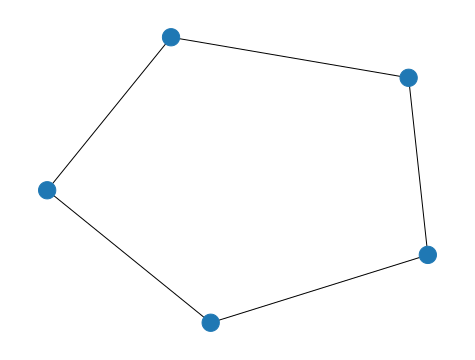

In [3]:
num_sites = 5
t = 1.0

graph = rx.PyGraph(multigraph=False)
graph.add_nodes_from(range(num_sites))
edge_list = [
    (0, 1, t),
    (1, 2, t),
    (2, 3, t),
    (3, 4, t),
    (4, 0, t),
]

graph.add_edges_from(edge_list)
line_unit_cell = Lattice(graph)

line_unit_cell.draw()
plt.show()

In [4]:
heisenberg_model = HeisenbergModel.uniform_parameters(
    lattice=line_unit_cell,
    uniform_interaction=1.0,
    uniform_onsite_potential=0.0,
)

logarithmic_mapper = LogarithmicMapper()
hamiltonian = 4 * logarithmic_mapper.map(heisenberg_model.second_q_ops().simplify())
hamiltonian

PauliSumOp(SparsePauliOp(['ZZIII', 'IZZII', 'IIZZI', 'ZIIIZ', 'IIIZZ', 'YYIII', 'IYYII', 'IIYYI', 'YIIIY', 'IIIYY', 'XXIII', 'IXXII', 'IIXXI', 'XIIIX', 'IIIXX'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j]), coeff=1)

In [6]:
print(hamiltonian.eval().primitive.data.astype(int))

[[5 0 0 ... 0 0 0]
 [0 1 2 ... 0 0 0]
 [0 2 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 2 0]
 [0 0 0 ... 2 1 0]
 [0 0 0 ... 0 0 5]]


/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_26890/1530903205.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(hamiltonian.eval().primitive.data.astype(int))


In [9]:
print(latex_array(hamiltonian.eval().primitive.data.astype(int)))

\begin{bmatrix}
  5 & 0 & 0 & ... & 0 & 0 & 0\\
  0 & 1 & 2 & ... & 0 & 0 & 0\\
  0 & 2 & 1 & ... & 0 & 0 & 0\\
  ...\\
  0 & 0 & 0 & ... & 1 & 2 & 0\\
  0 & 0 & 0 & ... & 2 & 1 & 0\\
  0 & 0 & 0 & ... & 0 & 0 & 5\\
\end{bmatrix}


/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_26890/3808117855.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  print(latex_array(hamiltonian.eval().primitive.data.astype(int)))


In [10]:
for jawn in hamiltonian.eval().primitive.data.astype(int):
    print("{", ",".join(map(str, jawn)), "},")

{ 5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,2,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,0,2,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,0,0,2,0,-3,2,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,0,0,0,0,2,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0 },
{ 0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,0,0,0,0,2,0,0,0,-3,2,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0 },
{ 0,0,0,0,0,0,2,0,0,2,-3,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,0,0,0,0,0,0,2,0,0,0,-3,0,2,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0 },
{ 0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0 },
{ 0,0,0,0,0,0,0,0,0,0,0,2,0,-3,2,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0 },
{ 0,0,0,0,0,0,0,0,0,0,0,0,0,2

/var/folders/r1/027lgns16j553ds7rms76qf80000gn/T/ipykernel_26890/4023989667.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  for jawn in hamiltonian.eval().primitive.data.astype(int):
